In [1]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import datetime
import math
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

2024-10-15 12:27:46.235033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 12:27:46.248191: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-15 12:27:46.252064: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-15 12:27:46.261622: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-15 12:27:47.153504: W tensorflow/compiler/tf2

In [2]:
from tensorflow.keras import mixed_precision

# # Set the global policy to mixed precision
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

I0000 00:00:1728955668.309504  130953 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728955668.898938  130953 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728955668.901380  130953 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [3]:
# import os

# # Set the environment variable
# os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


I0000 00:00:1728955668.939981  130953 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728955668.942410  130953 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728955668.948075  130953 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728955669.048731  130953 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [6]:
# data = pd.read_csv("C:\Users\alanx\OneDrive - The University of Sydney (Students)\Thesis\Deep Learning\wifi_localization\data\csv\ultimate_combined.csv")
data = pd.read_csv("data/csv/ultimate_combined.csv")
# data = pd.read_csv("data/csv/still/still.csv")
# data = pd.read_csv("data/csv/still_with_receiver/still_with_receiver.csv")

data.head()

,nc,rssi,rssi1,rssi2,subcarriers,ant1_amplitude,ant2_amplitude,ant1_phase,ant2_phase,with_receiver,coord1,coord2,ant1_amplitude_cluster,ant2_amplitude_cluster
0,1,-0.910605,-0.551767,-0.947813,1,0.080161,0.716936,1.632341,0.081637,0,6,2,0.0,1.0
1,1,-0.910605,-0.551767,-0.947813,2,0.050665,0.765282,1.613039,0.069161,0,6,2,0.0,1.0
2,1,-0.910605,-0.551767,-0.947813,3,0.034689,0.716998,1.575497,0.066240,0,6,2,0.0,1.0
3,1,-0.910605,-0.551767,-0.947813,4,-0.014982,0.698775,1.568640,0.054993,0,6,2,0.0,1.0
4,1,-0.910605,-0.551767,-0.947813,5,-0.038545,0.842687,1.580335,0.041922,0,6,2,0.0,1.0


In [7]:
# data.drop('with_receiver', axis=1, inplace=True)
data.drop('nc', axis=1, inplace=True)
data.drop('ant1_phase', axis=1, inplace=True)
data.drop('ant2_phase', axis=1, inplace=True)

In [8]:
data = pd.concat([data, pd.get_dummies(data['subcarriers'], prefix='subcarrier')], axis=1)
data.drop('subcarriers', axis=1, inplace=True)
data.head()

,rssi,rssi1,rssi2,ant1_amplitude,ant2_amplitude,with_receiver,coord1,coord2,ant1_amplitude_cluster,ant2_amplitude_cluster,...,subcarrier_47,subcarrier_48,subcarrier_49,subcarrier_50,subcarrier_51,subcarrier_52,subcarrier_53,subcarrier_54,subcarrier_55,subcarrier_56
0,-0.910605,-0.551767,-0.947813,0.080161,0.716936,0,6,2,0.0,1.0,...,False,False,False,False,False,False,False,False,False,False
1,-0.910605,-0.551767,-0.947813,0.050665,0.765282,0,6,2,0.0,1.0,...,False,False,False,False,False,False,False,False,False,False
2,-0.910605,-0.551767,-0.947813,0.034689,0.716998,0,6,2,0.0,1.0,...,False,False,False,False,False,False,False,False,False,False
3,-0.910605,-0.551767,-0.947813,-0.014982,0.698775,0,6,2,0.0,1.0,...,False,False,False,False,False,False,False,False,False,False
4,-0.910605,-0.551767,-0.947813,-0.038545,0.842687,0,6,2,0.0,1.0,...,False,False,False,False,False,False,False,False,False,False


# Model

In [9]:
model_type = "dnn"

In [10]:
X = data.drop(columns=['coord1', 'coord2']) 
y = data[['coord1', 'coord2']]

# X = X.values.astype(np.float32)
# y = y.values.astype(np.float32)

In [11]:
# np.save('preprocessed_X.npy', X)
# np.save('preprocessed_y.npy', y)

In [12]:
# X = np.load('preprocessed_X.npy')
# y = np.load('preprocessed_y.npy')

In [13]:
# dataset = tf.data.Dataset.from_tensor_slices((X, y))

# batch_size = 128  # Adjust based on your GPU memory

# dataset = dataset.shuffle(buffer_size=10000)
# dataset = dataset.batch(batch_size)
# dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [14]:
# First, split the data into training and a temporary set (which will later be split into validation and test sets)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)  # 60% train, 40% temp

# Now, split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 20% val, 20% test

# Check the shapes of your splits
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (1048395, 64)
Validation set shape: (349465, 64)
Test set shape: (349466, 64)


In [15]:
def create_dnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))

    # Hidden layers
    # model.add(layers.Dense(8192, activation='relu'))
    # model.add(layers.Dense(4096, activation='relu'))
    # model.add(layers.Dense(2048, activation='relu'))
    # model.add(layers.Dense(2048, activation='relu'))
    # model.add(layers.Dense(2048, activation='relu'))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    # model.add(layers.Dense(256, activation='relu'))
    # model.add(layers.Dense(128, activation='relu'))
    # model.add(layers.Dense(64, activation='relu'))
    # model.add(layers.Dense(32, activation='relu'))
    # model.add(layers.Dense(16, activation='relu'))

    # Output layer
    model.add(layers.Dense(2))

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


# Example of creating the model, input_shape should be (number of features,)
input_shape = (X_train.shape[1],)  # Adjust based on your number of features
model = create_dnn_model(input_shape)

# Print the model summary
model.summary()

/home/alan-xie/Documents/Thesis/wifi_localization/.venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1728955671.946218  130953 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728955671.947561  130953 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728955671.948615  130953 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA no

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,642,498 (6.27 MB)

 Trainable params: 1,642,498 (6.27 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")
# Train the model
with tf.device('/GPU:0'):
    history = model.fit(
                        # dataset,
                        X_train, y_train, 
                        epochs=30, 
                        batch_size=128, 
                        validation_data=(X_val, y_val),
                        callbacks=[tensorboard_callback, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

    # Evaluate the model on test data
    test_loss, test_mae = model.evaluate(X_test, y_test)
    print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")


Epoch 1/30


I0000 00:00:1728955673.917600  134165 service.cc:146] XLA service 0x79f3c4005430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728955673.917614  134165 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-10-15 12:27:53.939517: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-15 12:27:54.066973: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-15 12:27:54.759119: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_201', 132 bytes spill stores, 132 bytes spill loads

2024-10-15 12:27:55.161771: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in fu

  95/8191 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 8.3050 - mae: 2.1783  

I0000 00:00:1728955678.085496  134165 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8167/8191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1901 - mae: 1.0923

2024-10-15 12:28:12.036409: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_201', 20 bytes spill stores, 20 bytes spill loads

2024-10-15 12:28:12.401303: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_201', 200 bytes spill stores, 200 bytes spill loads

2024-10-15 12:28:12.484237: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_201', 344 bytes spill stores, 252 bytes spill loads

2024-10-15 12:28:13.000777: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_215', 16 bytes spill stores, 16 bytes spill loads

2024-10-15 12:28:13.027070: I external/local_xla/xla/stream_

8191/8191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1886 - mae: 1.0918

2024-10-15 12:28:18.679805: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 44 bytes spill stores, 44 bytes spill loads

2024-10-15 12:28:18.761267: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 12 bytes spill stores, 12 bytes spill loads

2024-10-15 12:28:18.821930: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 200 bytes spill stores, 200 bytes spill loads



8191/8191 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 2.1885 - mae: 1.0918 - val_loss: 1.2059 - val_mae: 0.7230
Epoch 2/30
8191/8191 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 1.1221 - mae: 0.6905 - val_loss: 0.9241 - val_mae: 0.5911
Epoch 3/30
8191/8191 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.8772 - mae: 0.5733 - val_loss: 0.7482 - val_mae: 0.5088
Epoch 4/30
8191/8191 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.7126 - mae: 0.4967 - val_loss: 0.6022 - val_mae: 0.4481
Epoch 5/30
8191/8191 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.5750 - mae: 0.4353 - val_loss: 0.5109 - val_mae: 0.3965
Epoch 6/30
8191/8191 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.4788 - mae: 0.3889 - val_loss: 0.4623 - val_mae: 0.3755
Epoch 7/30
8191/8191 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.4144 - mae: 0.3566 - val_loss: 0.4277 - val_mae: 0.3554
Epoch 8/30
8191/8191 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.3660 - mae: 0.3316 - val_loss: 0.3747 - val_mae: 0.3335
Epoch 9/30
8191/8191 ━━━━━━━━━━━━━━━━━━━━ 1

2024-10-15 12:35:00.757509: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 132 bytes spill stores, 132 bytes spill loads



10869/10921 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - loss: 0.1699 - mae: 0.2089

2024-10-15 12:35:08.590116: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 44 bytes spill stores, 44 bytes spill loads

2024-10-15 12:35:08.622153: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 12 bytes spill stores, 12 bytes spill loads

2024-10-15 12:35:08.894653: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 200 bytes spill stores, 200 bytes spill loads



10921/10921 ━━━━━━━━━━━━━━━━━━━━ 10s 758us/step - loss: 0.1699 - mae: 0.2089
Test Loss: 0.16875237226486206, Test MAE: 0.2086503952741623


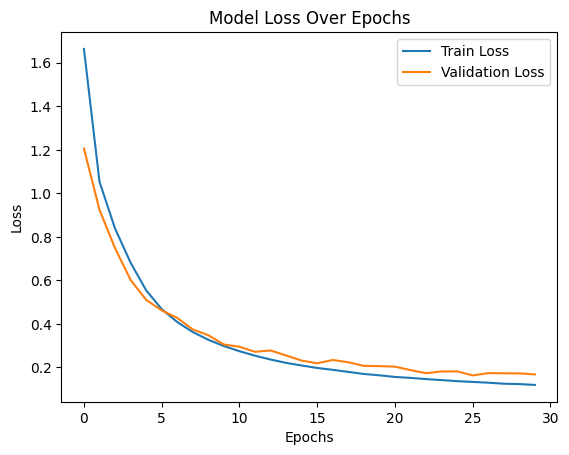

In [17]:
# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [18]:
# After training your model
y_pred = model.predict(X_test)

10921/10921 ━━━━━━━━━━━━━━━━━━━━ 7s 601us/step


In [19]:
# Convert y_test to NumPy array with float64 data type
y_test_np = y_test.to_numpy(dtype=np.float64)

# Ensure y_pred is a NumPy array with float64 data type
y_pred_np = np.array(y_pred, dtype=np.float64)

In [20]:
# Assuming y_test and y_pred are NumPy arrays
absolute_errors = np.abs(y_test_np - y_pred_np)
coordinate_ranges = np.ptp(y_test_np, axis=0)  # Peak to peak (max - min) along each coordinate

# Avoid division by zero
coordinate_ranges[coordinate_ranges == 0] = 1

relative_errors = absolute_errors / coordinate_ranges
mean_relative_error = np.mean(relative_errors, axis=0)

print(f"Mean Relative Error for coord1: {mean_relative_error[0]:.4f}")
print(f"Mean Relative Error for coord2: {mean_relative_error[1]:.4f}")


Mean Relative Error for coord1: 0.0385
Mean Relative Error for coord2: 0.0372


In [21]:
from scipy.stats import spearmanr

rho_coord1, _ = spearmanr(y_test_np[:, 0], y_pred_np[:, 0])
rho_coord2, _ = spearmanr(y_test_np[:, 1], y_pred_np[:, 1])

print(f"Spearman's Rank Correlation for coord1: {rho_coord1:.4f}")
print(f"Spearman's Rank Correlation for coord2: {rho_coord2:.4f}")


Spearman's Rank Correlation for coord1: 0.9675
Spearman's Rank Correlation for coord2: 0.9513


In [22]:
# Create a mapping from coordinate pairs to class labels
unique_coords = np.unique(y_test_np, axis=0)
coord_to_label = {tuple(coord): idx for idx, coord in enumerate(unique_coords)}

# Convert coordinates to labels
y_test_labels = np.array([coord_to_label[tuple(coord)] for coord in y_test_np])
y_pred_labels = np.array([coord_to_label.get(tuple(coord), -1) for coord in y_pred_np])  # Use -1 for unknowns


In [23]:
# from sklearn.metrics import accuracy_score, confusion_matrix

# # Filter out predictions that don't map to a valid label
# valid_indices = y_pred_labels != -1
# accuracy = accuracy_score(y_test_labels[valid_indices], y_pred_labels[valid_indices])
# print(f"Classification Accuracy: {accuracy:.4f}")


In [24]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import ConfusionMatrixDisplay

# cm = confusion_matrix(y_test_labels[valid_indices], y_pred_labels[valid_indices])
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap='Blues')
# plt.title('Confusion Matrix of Predicted vs Actual Classes')
# plt.show()

In [25]:
scaler = StandardScaler()
y_test_scaled = scaler.fit_transform(y_test_np)
y_pred_scaled = scaler.transform(y_pred_np)

# Compute Mean Squared Error on standardized data
from sklearn.metrics import mean_squared_error

mse_scaled = mean_squared_error(y_test_scaled, y_pred_scaled)
print(f"MSE on Standardized Coordinates: {mse_scaled:.4f}")


MSE on Standardized Coordinates: 0.0588


In [38]:
def custom_accuracy(y_true, y_pred, tolerance):
    # Count predictions within a certain tolerance
    correct_predictions = np.all(np.abs(y_true - y_pred) <= tolerance, axis=1)
    accuracy = np.mean(correct_predictions)
    return accuracy

tolerances = [1, 0.5, 0.1]  # Adjust based on your coordinate system

for tolerance in tolerances:
    accuracy = custom_accuracy(y_test_np, y_pred_np, tolerance)
    print(f"Accuracy within tolerance {tolerance}: {accuracy:.4f}")

accuracy = custom_accuracy(y_test_np, y_pred_np, 1)

Accuracy within tolerance 1: 0.9480
Accuracy within tolerance 0.5: 0.8500
Accuracy within tolerance 0.1: 0.3441


In [39]:
tolerances = [1, 0.5, 0.1]  # Adjust based on your coordinate system

y_pred_np_rounded = np.round(y_pred_np)

for tolerance in tolerances:
    accuracy = custom_accuracy(y_test_np, y_pred_np_rounded, tolerance)
    print(f"Accuracy within tolerance {tolerance}: {accuracy:.4f}")

accuracy = custom_accuracy(y_test_np, y_pred_np, 1)

Accuracy within tolerance 1: 0.9747
Accuracy within tolerance 0.5: 0.8500
Accuracy within tolerance 0.1: 0.8500


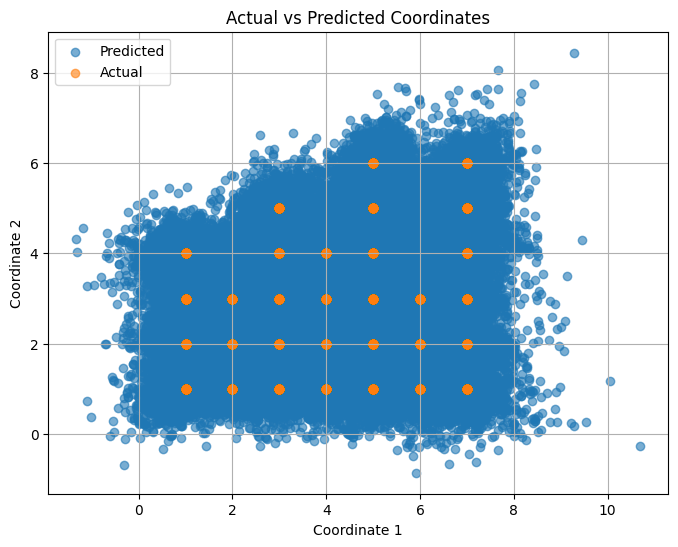

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_np[:, 0], y_pred_np[:, 1], label='Predicted', alpha=0.6)
plt.scatter(y_test_np[:, 0], y_test_np[:, 1], label='Actual', alpha=0.6)
plt.xlabel('Coordinate 1')
plt.ylabel('Coordinate 2')
plt.title('Actual vs Predicted Coordinates')
plt.legend()
plt.grid(True)
plt.show()


In [41]:
# MAE for each coordinate
mae_coord1 = mean_absolute_error(y_test_np[:, 0], y_pred_np[:, 0])
mae_coord2 = mean_absolute_error(y_test_np[:, 1], y_pred_np[:, 1])

# Overall MAE
mae_overall = np.mean([mae_coord1, mae_coord2])

print(f"MAE for coord1: {mae_coord1:.4f}")
print(f"MAE for coord2: {mae_coord2:.4f}")
print(f"Overall MAE: {mae_overall:.4f}")

# RMSE for each coordinate
rmse_coord1 = np.sqrt(mean_squared_error(y_test_np[:, 0], y_pred_np[:, 0]))
rmse_coord2 = np.sqrt(mean_squared_error(y_test_np[:, 1], y_pred_np[:, 1]))

# Overall RMSE
rmse_overall = np.mean([rmse_coord1, rmse_coord2])

print(f"RMSE for coord1: {rmse_coord1:.4f}")
print(f"RMSE for coord2: {rmse_coord2:.4f}")
print(f"Overall RMSE: {rmse_overall:.4f}")

# Calculate Euclidean distances
distance_errors = np.linalg.norm(y_test_np - y_pred_np, axis=1)
mean_distance_error = np.mean(distance_errors)

print(f"Mean Euclidean Distance Error: {mean_distance_error:.4f} units")

# R-squared for each coordinate
r2_coord1 = r2_score(y_test_np[:, 0], y_pred_np[:, 0])
r2_coord2 = r2_score(y_test_np[:, 1], y_pred_np[:, 1])

print(f"R-squared for coord1: {r2_coord1:.4f}")
print(f"R-squared for coord2: {r2_coord2:.4f}")

# Median Absolute Error for each coordinate
medae_coord1 = median_absolute_error(y_test_np[:, 0], y_pred_np[:, 0])
medae_coord2 = median_absolute_error(y_test_np[:, 1], y_pred_np[:, 1])

print(f"Median Absolute Error for coord1: {medae_coord1:.4f}")
print(f"Median Absolute Error for coord2: {medae_coord2:.4f}")

MAE for coord1: 0.2311
MAE for coord2: 0.1862
Overall MAE: 0.2087
RMSE for coord1: 0.4614
RMSE for coord2: 0.3530
Overall RMSE: 0.4072
Mean Euclidean Distance Error: 0.3284 units
R-squared for coord1: 0.9462
R-squared for coord2: 0.9362
Median Absolute Error for coord1: 0.1055
Median Absolute Error for coord2: 0.0905


In [42]:
now = datetime.datetime.now()
date_time = now.strftime("%m-%d-%H-%M")

model.save(f"./models/{date_time}-{model_type}-{accuracy:.2f}.keras")

In [43]:
from sklearn.model_selection import KFold
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scores = []

for train_index, test_index in kf.split(X):
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
    
    # Create and train the model
    model = create_dnn_model(input_shape=(X_train_cv.shape[1],))
    model.fit(X_train_cv, y_train_cv, epochs=30, batch_size=128, verbose=0)
    
    # Evaluate the model
    y_pred_cv = model.predict(X_test_cv)
    mae_cv = np.mean(np.abs(y_test_cv - y_pred_cv))
    mae_scores.append(mae_cv)

print(f"Cross-validated MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")

/home/alan-xie/Documents/Thesis/wifi_localization/.venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10921/10921 ━━━━━━━━━━━━━━━━━━━━ 7s 594us/step


/home/alan-xie/Documents/Thesis/wifi_localization/.venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
2024-10-15 12:49:33.251800: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_201', 20 bytes spill stores, 20 bytes spill loads

2024-10-15 12:49:33.277449: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_201', 12 bytes spill stores, 12 bytes spill loads

2024-10-15 12:49:33.771491: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_201', 200 bytes spill stores, 200 bytes spill loads

2024-10-15 12:49:33.879359: I external/local_xla/xla/stream_executor/cuda/cuda_as

10921/10921 ━━━━━━━━━━━━━━━━━━━━ 7s 600us/step


/home/alan-xie/Documents/Thesis/wifi_localization/.venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10921/10921 ━━━━━━━━━━━━━━━━━━━━ 7s 589us/step


/home/alan-xie/Documents/Thesis/wifi_localization/.venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10921/10921 ━━━━━━━━━━━━━━━━━━━━ 7s 587us/step


/home/alan-xie/Documents/Thesis/wifi_localization/.venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


10921/10921 ━━━━━━━━━━━━━━━━━━━━ 7s 589us/step
Cross-validated MAE: 0.1802 ± 0.0035


In [44]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, scoring='neg_mean_squared_error')

10921/10921 ━━━━━━━━━━━━━━━━━━━━ 6s 589us/step
10921/10921 ━━━━━━━━━━━━━━━━━━━━ 6s 536us/step
10921/10921 ━━━━━━━━━━━━━━━━━━━━ 6s 529us/step
10921/10921 ━━━━━━━━━━━━━━━━━━━━ 6s 534us/step
10921/10921 ━━━━━━━━━━━━━━━━━━━━ 6s 535us/step
10921/10921 ━━━━━━━━━━━━━━━━━━━━ 6s 524us/step
10921/10921 ━━━━━━━━━━━━━━━━━━━━ 6s 542us/step
10921/10921 ━━━━━━━━━━━━━━━━━━━━ 6s 549us/step
10921/10921 ━━━━━━━━━━━━━━━━━━━━ 6s 554us/step
10921/10921 ━━━━━━━━━━━━━━━━━━━━ 6s 557us/step
10921/10921 ━━━━━━━━━━━━━━━━━━━━ 6s 544us/step
10921/10921 ━━━━━━━━━━━━━━━━━━━━ 6s 555us/step
10921/10921 ━━━━━━━━━━━━━━━━━━━━ 6s 527us/step
10921/10921 ━━━━━━━━━━━━━━━━━━━━ 6s 551us/step
10921/10921 ━━━━━━━━━━━━━━━━━━━━ 6s 546us/step
10921/10921 ━━━━━━━━━━━━━━━━━━━━ 6s 562us/step
10921/10921 ━━━━━━━━━━━━━━━━━━━━ 6s 533us/step
10921/10921 ━━━━━━━━━━━━━━━━━━━━ 6s 552us/step
10921/10921 ━━━━━━━━━━━━━━━━━━━━ 6s 543us/step
10921/10921 ━━━━━━━━━━━━━━━━━━━━ 6s 564us/step
10921/10921 ━━━━━━━━━━━━━━━━━━━━ 6s 556us/step
10921/10921 ━

['rssi' 'rssi1' 'rssi2' 'ant1_amplitude' 'ant2_amplitude' 'with_receiver'
 'coord1' 'coord2' 'ant1_amplitude_cluster' 'ant2_amplitude_cluster'
 'subcarrier_1' 'subcarrier_2' 'subcarrier_3' 'subcarrier_4'
 'subcarrier_5' 'subcarrier_6' 'subcarrier_7' 'subcarrier_8'
 'subcarrier_9' 'subcarrier_10' 'subcarrier_11' 'subcarrier_12'
 'subcarrier_13' 'subcarrier_14' 'subcarrier_15' 'subcarrier_16'
 'subcarrier_17' 'subcarrier_18' 'subcarrier_19' 'subcarrier_20'
 'subcarrier_21' 'subcarrier_22' 'subcarrier_23' 'subcarrier_24'
 'subcarrier_25' 'subcarrier_26' 'subcarrier_27' 'subcarrier_28'
 'subcarrier_29' 'subcarrier_30' 'subcarrier_31' 'subcarrier_32'
 'subcarrier_33' 'subcarrier_34' 'subcarrier_35' 'subcarrier_36'
 'subcarrier_37' 'subcarrier_38' 'subcarrier_39' 'subcarrier_40'
 'subcarrier_41' 'subcarrier_42' 'subcarrier_43' 'subcarrier_44'
 'subcarrier_45' 'subcarrier_46' 'subcarrier_47' 'subcarrier_48'
 'subcarrier_49' 'subcarrier_50' 'subcarrier_51' 'subcarrier_52'
 'subcarrier_53' 'sub

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 2 with shape (64,) and arg 3 with shape (66,).

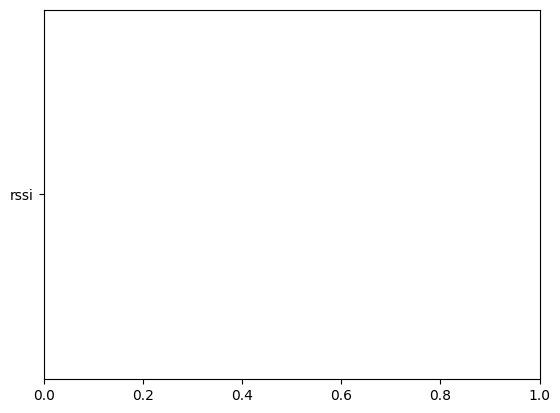

In [45]:
# Get the mean importance scores
importances = result.importances_mean
feature_names = data.columns.values

print(feature_names)

# Print or plot feature importances
for feature, importance in zip(feature_names, importances):
    print(f"Feature: {feature}, Importance: {importance}")

plt.barh(feature_names[:66], importances)
plt.xlabel('Permutation Importance')
plt.show()